In [1]:
import pandas as pd
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay
import datetime
import warnings
from copy import deepcopy
import numpy as np
%matplotlib inline
from scipy.stats import linregress
import matplotlib.pyplot as plt
from math import sqrt
import scipy.stats as st
import pyfolio as pf

In [2]:
symbols = ['VTI', 'VWO', 'VEA', 'VIG', 'XLE', 'SPY']

start = datetime.datetime(2010,1,1)
end = datetime.datetime.now()

In [3]:
prices = pd.DataFrame()
for symbol in symbols:
    f = web.DataReader(symbol, 'yahoo', start, end)
    f['symbol'] = symbol
    prices = pd.concat([prices, f])
    #print symbol
prices;

In [4]:
prices = prices.pivot(columns="symbol", values="Adj Close")

In [6]:
dividends_and_splits= pd.DataFrame()

for symbol in symbols:
    f = web.DataReader(symbol, 'yahoo-actions')
    if len(f) > 0:
        f['symbol'] = symbol
        dividends_and_splits = pd.concat([dividends_and_splits, f])

In [9]:
# TODO: check user account's free cash and update it accordingly
def execute_order(order, holdings):
    'Simulates the broker/market and creates a transaction.'
    transaction = deepcopy(order)
    symbol, shares, time = order['symbol'], order['shares'], order['time']
    
    if order['action']=='sell':
        if (holdings is None or  
            not (symbol in holdings.index) or 
            holdings.loc[symbol]['shares'] < order['shares']):
            
            warnings.warn('Your order ' + str(order) + ' is rejected.')
            transaction['status'] = 'rejected'
            return transaction
    
    transaction['status'] = 'accepted'
    price = get_price(symbol, time)
    commision = commision_calculation(order, price)
    transaction['price'], transaction['commision'] = price, commision
    return transaction

def get_price(symbol, time = None, price_source=prices):
    'Returns the last price of the symbol. We assume that prices is a pandas object.'
    if time is None:
        time = str(datetime.datetime.now())
    
    try: 
        closest_time = (price_source.index[time >= price_source.index]).sort_values()[-1]
        return price_source[symbol].loc[closest_time]
    except ValueError:
        raise ValueError("We don't have historical data for an order at " + order_time)
    except IndexError:
        raise IndexError("We don't have historical data for an order at " + order_time)

def commision_calculation(order, price, commission_ratio=0.0001):
    'Calculates commision to be paid.'
    return order['shares']*price*commission_ratio

def current_time(prices=prices):
    'Returns the maximum date from the prices table.'
    return max(prices.index).strftime("%Y-%m-%d")

In [10]:
def apply_transaction(transaction, positions, trades):
    'Update positions and trades with the transaction.'
    if transaction["status"] == "accepted":
        symbol, action, shares = transaction["symbol"], transaction["action"], transaction["shares"]
        price, time = transaction["price"], transaction['time']
        if action == "buy":
            position = {'type':'long', 
                        'symbol':symbol, 
                        'initial_shares':shares, 
                        'shares':shares, 
                        'price': price, 
                        'cost': price*shares, 
                        'time': time}
            positions.append(position)
        else:
            match_sell_transaction_to_position(transaction, positions, trades)

def match_sell_transaction_to_position(transaction, positions, trades):
    """We will select the positions with the same symbol and order them according to time desc.
    Until we finish the order's volume we match it with a position. If a position is fulfilled,
    we continue with the next one in the order. We create a trade, we remove the amount traded 
    from the position. If the position's volume is empty we remove the position from the list.
    
    Assumption: Since the broker rejects sells orders greater then our holdings, 
    we assume that transaction.shares <= sum(positions.shares)."""
    
    sorted(positions, key=lambda k: k['time']) 
    shares, time, symbol = transaction["shares"], transaction["time"], transaction["symbol"]
    
    for position in positions:
        if not shares > 0:
            break
        if position["symbol"] == transaction["symbol"] and position["shares"] > 0:
            traded_shares = min(shares, position['shares'])
            buy_price, sell_price = position["price"], transaction["price"]
            profit = (sell_price - buy_price) * traded_shares
            trade = {'symbol':symbol, 
                     'shares':traded_shares, 
                     'time':time, 
                     'buy_price': buy_price, 
                     'sell_price': sell_price, 
                     'profit': profit}
            trades.append(trade)
            shares -= traded_shares
            position["shares"] = position["shares"] - traded_shares
            position["cost"] = position["shares"] * buy_price

In [11]:
def calculate_portfolio(positions):
    if len(positions) == 0:
        return []
    else:
        temp = pd.DataFrame(positions)
        return temp.pivot_table(index='symbol', aggfunc='sum', values=["cost", 'shares'])

In [12]:
def execute_orders(orders, transactions, positions, trades):
    """Calls execute_order function for each order in the order list.
    Updates transaction, position and trade lists.
    """
    
    portfolio = calculate_portfolio(positions)
    for order in orders:
        transaction = execute_order(order, portfolio)
        transactions.append(transaction)
        apply_transaction(transaction, positions, trades)
        portfolio = calculate_portfolio(positions)

In [13]:
def get_prices(assets, time = None):
    return {symbol: get_price(symbol, time) for symbol in assets}

#pd.Series(get_prices(portfolio.index))

In [14]:
def current_performance(portfolio, time=None):
    portfolio["current_price"] = pd.Series(get_prices(portfolio.index, time))
    portfolio["market_value"] = portfolio["shares"] * portfolio["current_price"]
    portfolio["profit"] = portfolio["market_value"] - portfolio["cost"]
    
    total_market_value = portfolio.market_value.sum()
    portfolio["weight"] = portfolio["market_value"] / total_market_value

In [15]:
def historical_performance(transactions, prices):
    "Returns historical market value of a portfolio."
    starting_date = min(transactions, key=lambda x: x["time"])["time"]
    ending_date = datetime.datetime.now()
    symbols = set([t["symbol"] for t in transactions if t["status"]=="accepted"] )
    
    symbol_price = (prices.loc[starting_date:ending_date][list(symbols)])
    
    holdings_list = holdings(transactions)
    
    return (holdings_list
            .fillna(method='ffill')
            .reindex(symbol_price.index.union(holdings_list.index))
            .fillna(method='ffill')
            .reindex(symbol_price.index)
            .mul(symbol_price).sum(axis=1)
           )

def holdings(transactions):
    t = pd.DataFrame(transactions)
    t["sign"] = t["action"].apply(lambda x: 1 if x=="buy" else -1)
    t["signed_shares"] = t["sign"] * t["shares"]
    t["time"] = pd.to_datetime(t["time"])
    
    return (t.query("status == 'accepted'")
     .pivot_table(values="signed_shares", columns="symbol", index="time")
     .cumsum()
    )

In [17]:
def compare_with_benchmark(historical_value, benchmark_symbol="XU100.IS"):
    algo = (historical_value[historical_value > 0].pct_change() + 1).cumprod()
    algo.name = "Algorithm"
    algo.plot(legend=True)
    print "Algorithm performance:", (algo.ix[-1] - 1)*100
    
    start_date = historical_value.index[0]

    benchmark = (prices[benchmark_symbol].dropna().pct_change().loc[start_date:] + 1).cumprod()
    benchmark.name = "Benchmark"
    benchmark.plot(legend = True, figsize=[15,10])
    print "Benchmark performance:", (benchmark.ix[-1] - 1)*100

In [18]:
def paid_dividends(transactions, dividends):
    
    start_date = min(transactions, key=lambda x: x["time"])["time"]
    end_date = datetime.datetime.now()
    
    H= holdings(transactions)
    H.index = pd.to_datetime(H.index)
    
    H = (H.reindex(pd.date_range(start=start_date, end=end_date, freq='D'))
         .fillna(method='ffill')
         .fillna(0))
    
    return (pd.melt(Dividends[Dividends.symbol.apply(lambda x: x in H.columns)]
                    .reset_index()
                    .rename(columns={'index':'time'})
                    .pivot_table(values="value", columns="symbol", index = 'time')
                    .reindex(H.index)
                    .mul(H)
                    .reset_index()
                    .rename(columns={'index':'time'})
                    , id_vars = 'time', var_name= 'symbol', value_name='paid_dividend'
                    )
            ).query("paid_dividend > 0")

In [19]:
def rebalance(portfolio, target_weights, target_value = None, time = None):
    """New weights is a dictionary of {symbol: weights}.
    Creates orders to make portfolio's weight 'new weights'.
    Time indicates execution of rebalance operation.
    """
    if time is None:
        time = current_time()
    
    if target_value is None: 
        target_value = portfolio.market_value.sum()
        
    if len(portfolio)>0:
        target_weights = {s:target_weights[s] if s in target_weights.keys() else 0 
                          for s in set(portfolio.index | target_weights.keys())}
    print target_weights
    
    # check if the weights sum up to 1.
    assert(sum(target_weights.values()) == 1)
        
    rebalance_orders = []
    
    target_market_value = {s:target_weights[s]*target_value for s in target_weights.keys()}
    
    for symbol, weight in target_weights.iteritems():
        
        if len(portfolio)>0 and symbol in portfolio.index:
            delta_value = target_market_value[symbol] - portfolio["market_value"].loc[symbol]
            
            if weight:
                delta_lot = int(abs(delta_value / get_price(symbol, time)))
            else:
                delta_lot = portfolio["shares"].loc[symbol]
            
            if delta_lot:
                if delta_value > 0:
                    action = 'buy'
                else:
                    action = 'sell'
            
                order = {'symbol': symbol, 'shares': delta_lot, 'action': action, 'time': time}
                rebalance_orders.append(order)
        else:
            delta_lot = int(target_market_value[symbol] / get_price(symbol, time))
            order = {'symbol': symbol, 'shares': delta_lot, 'action': 'buy', 'time': time}
            rebalance_orders.append(order) 
    
    return rebalance_orders

# BACKTEST

In [20]:
capital_base = 100000
start, end = np.datetime64('2010-01-20 00:00:00'), datetime.datetime.now()
running_points = [date for date in prices.index if start <= date <= end]

In [22]:
def beta(price_data, start, end):
    returns = (prices.loc[start:end]
               #.resample('3BMS', 'first')
               .pct_change()
               .dropna())
    
    beta_values = {symbol: linregress(returns["SPY"], returns[symbol])[0] 
                   for symbol in price_data.columns if symbol != 'SPY'}
    return beta_values

In [23]:
portfolio, transactions, positions, trades = [], [], [], []

for t in running_points:
    time = t.strftime("%Y-%m-%d")
    
    if t in pd.date_range(start=running_points[0], periods=12, freq='BM'):
        print t
        print '-'*20
        beta_values = beta(prices, prices.index[0], t)
        for s in sorted(beta_values, key=beta_values.get, reverse=True):
            print s, beta_values[s]
            
        n = 5    
        new_weights = {s: 1./n for s in sorted(beta_values, key=beta_values.get, reverse=True)[:n]}
        #Calculations here...
        
        print new_weights
        
        target_value = None if len(portfolio) else capital_base
        
        if len(portfolio) > 0:
            current_performance(portfolio, time)
        
        rebalance_orders = rebalance(portfolio, new_weights, target_value, time)
        
        print "Before Orders"
        print "-"*20
        print portfolio
        print " "
        
        print "Orders"
        print "-"*20
        print pd.DataFrame(rebalance_orders)
        print " "
        execute_orders(rebalance_orders, transactions, positions, trades)
        portfolio = calculate_portfolio(positions)
        current_performance(portfolio, time)
        
        print "After Orders"
        print "-"*20 
        print portfolio
        print " "
        
portfolio = calculate_portfolio(positions)

2010-01-29 00:00:00
--------------------
VEA 1.20253961402
VWO 1.1080981124
XLE 1.01374864101
VTI 1.00786304416
VIG 0.731324292388
{'VTI': 0.2, 'XLE': 0.2, 'VWO': 0.2, 'VIG': 0.2, 'VEA': 0.2}
{'VTI': 0.2, 'XLE': 0.2, 'VWO': 0.2, 'VIG': 0.2, 'VEA': 0.2}
Before Orders
--------------------
[]
 
Orders
--------------------
  action  shares symbol        time
0    buy     422    VTI  2010-01-29
1    buy     424    XLE  2010-01-29
2    buy     622    VWO  2010-01-29
3    buy     509    VIG  2010-01-29
4    buy     763    VEA  2010-01-29
 
After Orders
--------------------
                cost  shares  current_price  market_value  profit    weight
symbol                                                                     
VEA     19983.700191     763      26.190957  19983.700191     0.0  0.199926
VIG     19996.509866     509      39.285874  19996.509866     0.0  0.200054
VTI     19987.933784     422      47.364772  19987.933784     0.0  0.199968
VWO     19990.663882     622      32.139331  19

In [24]:
current_performance(portfolio, time = '2016-08-04')

,cost,shares,current_price,market_value,profit,weight
symbol,,,,,,
VEA,21400.439632,814,36.042939,29338.952346,7938.512714,0.173807
VIG,20916.168376,529,84.098016,44487.850464,23571.682088,0.263551
VTI,20072.517188,423,109.746463,46422.753849,26350.236661,0.275013
VWO,19209.486484,593,36.461744,21621.814192,2412.327708,0.128090
XLE,19140.422352,407,66.168132,26930.429724,7790.007372,0.159539


Algorithm performance: 83.0476174227
Benchmark performance: 151.888515546


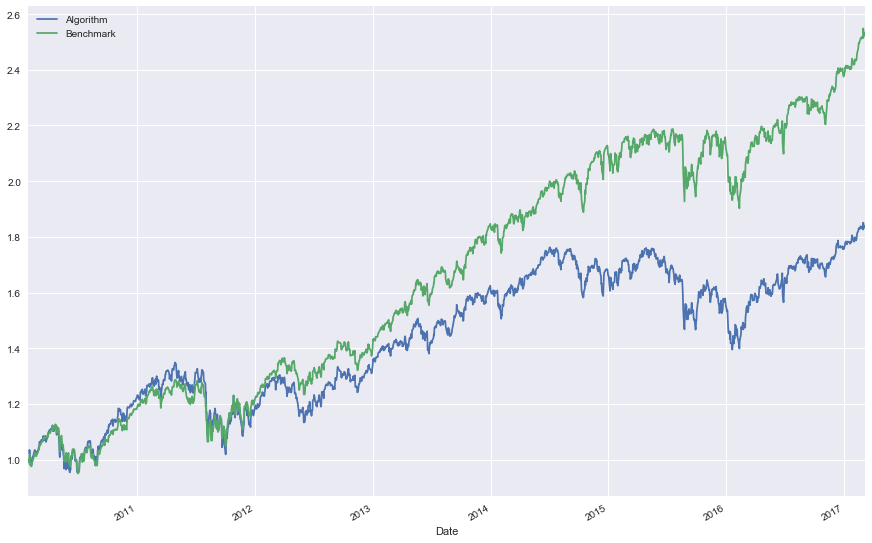

In [26]:
temp = historical_performance(transactions, prices)
compare_with_benchmark(temp, 'SPY')

In [27]:
temp = temp.pct_change()
temp = temp.tz_localize('utc')

Entire data start date: 2010-01-29
Entire data end date: 2017-03-07


Backtest Months: 85


Performance statistics,Backtest
annual_return,0.09
cum_returns_final,0.83
annual_volatility,0.17
sharpe_ratio,0.58
calmar_ratio,0.36
stability_of_timeseries,0.81
max_drawdown,-0.24
omega_ratio,1.11
sortino_ratio,0.82
skew,nan


Worst drawdown periods,net drawdown in %,peak date,valley date,recovery date,duration
0,24.48,2011-04-29,2011-10-03,2013-01-02,439
1,20.84,2014-07-03,2016-01-20,2016-12-07,635
2,15.13,2010-04-23,2010-07-02,2010-10-06,119
3,8.40,2013-05-21,2013-06-24,2013-09-10,81
4,7.32,2013-12-31,2014-02-03,2014-03-06,48




[-0.021 -0.042]


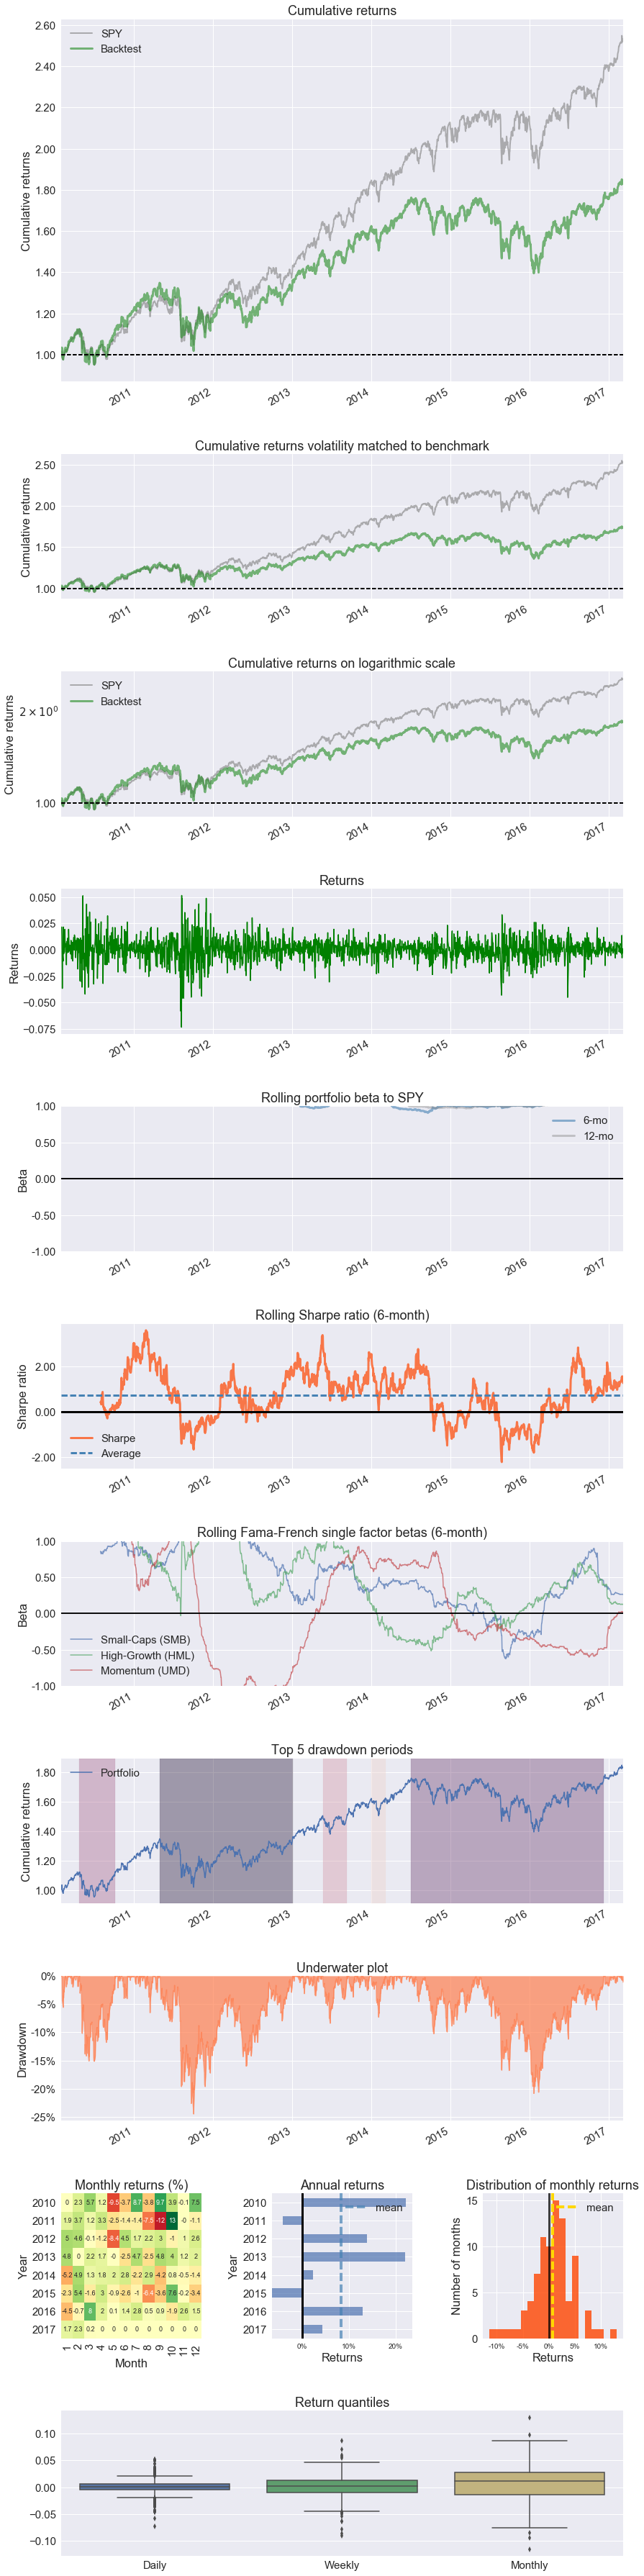

In [28]:
pf.create_returns_tear_sheet(temp)

In [21]:
# TODO: fill nan values
def momentum(price_data, start, end):
    momentum_values = {symbol: (price_data[symbol].loc[end] - price_data[symbol].loc[start]) 
                   for symbol in price_data.columns if symbol != 'SPY'}
    return momentum_values
pd.date_range(start=running_points[0], periods=12, freq='BM')
portfolio, transactions, positions, trades = [], [], [], []

for t in running_points:
    time = t.strftime("%Y-%m-%d")
    
    if t in pd.date_range(start=running_points[0], periods=12, freq='BM'):
        print t
        print '-'*20
        momentum_values = momentum(prices, t - pd.DateOffset(months=5) - 1*BDay(), t - 1*BDay())
        for s in sorted(momentum_values, key=momentum_values.get, reverse=True):
            print s, momentum_values[s]
            
        n = 5    
        
        if len(portfolio) == 0:
            new_weights = {s: 1./n for s in sorted(momentum_values, key=momentum_values.get, reverse=True)[:n]}
            print new_weights
            target_value = capital_base
            rebalance_orders = rebalance(portfolio, new_weights, target_value, time)
        else:
            potentials = {key:value for key, value in momentum_values.iteritems() if key not in portfolio.index }
            new_weights = {}
            
            for symbol in portfolio.index:
                if portfolio["market_value"].loc[symbol]:
                    if momentum_values[symbol] < 0:
                        s = sorted(potentials, key=potentials.get, reverse=True)[0]
                        print symbol + "out" + s + "in"
                        new_weights[s] = 1./n
                        del potentials[s]
                    else:
                        new_weights[symbol] = 1./n
              
            current_performance(portfolio, time)
            
            print new_weights
            rebalance_orders = rebalance(portfolio, new_weights, None, time)      
        
        print "Before Orders"
        print "-"*20
        print portfolio["market_value"].sum() if len(portfolio) else 0
        print portfolio
        print " "
        
        print "Orders"
        print "-"*20
        print pd.DataFrame(rebalance_orders)
        print " "
        
        print sum([order["shares"]*get_price(order["symbol"], time) for order in rebalance_orders if order["action"]=="buy"])
        print sum([order["shares"]*get_price(order["symbol"], time) for order in rebalance_orders if order["action"]=="sell"])
        
        execute_orders(rebalance_orders, transactions, positions, trades)
        portfolio = calculate_portfolio(positions)
        current_performance(portfolio, time)
        
        print "After Orders"
        print "-"*20 
        print portfolio
        print portfolio["market_value"].sum()
        print " "
        
portfolio = calculate_portfolio(positions)
temp = historical_performance(transactions, prices)
compare_with_benchmark(temp, 'SPY')
temp = temp.pct_change()
temp = temp.tz_localize('utc')

2010-01-29 00:00:00
--------------------


KeyError: 'the label [2009-08-28 00:00:00] is not in the [index]'

Entire data start date: 2010-01-29
Entire data end date: 2017-03-07


Backtest Months: 85


Performance statistics,Backtest
annual_return,0.09
cum_returns_final,0.83
annual_volatility,0.17
sharpe_ratio,0.58
calmar_ratio,0.36
stability_of_timeseries,0.81
max_drawdown,-0.24
omega_ratio,1.11
sortino_ratio,0.82
skew,nan


KeyboardInterrupt: 

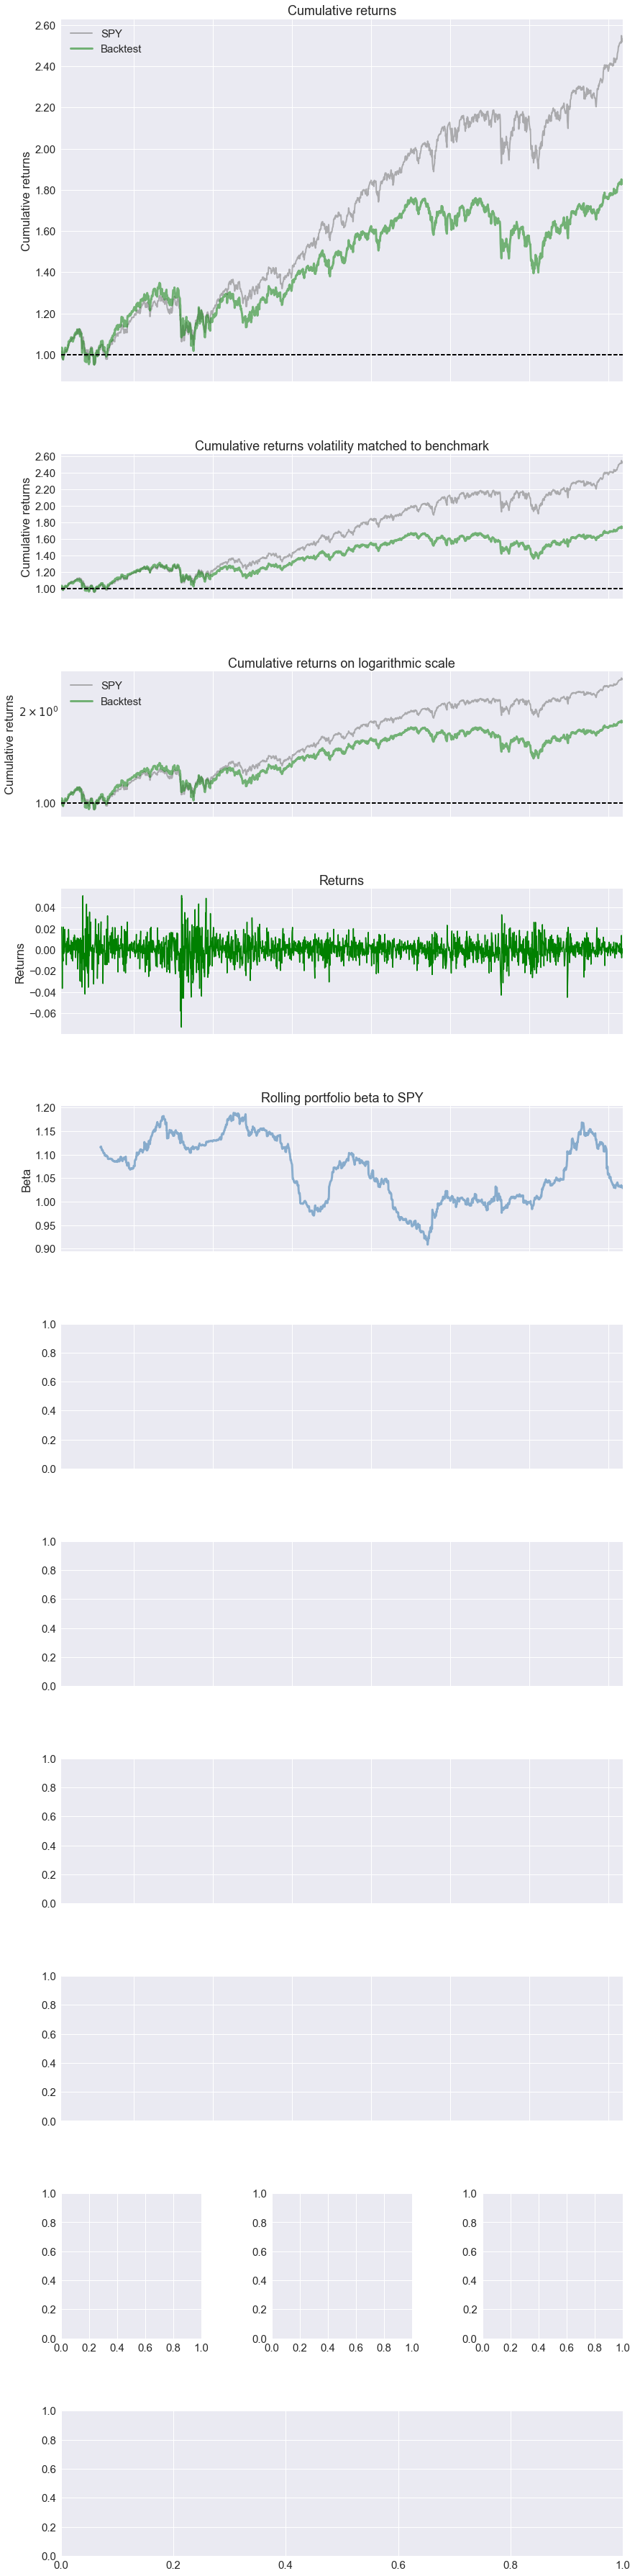

In [30]:
pf.create_returns_tear_sheet(temp)